In [9]:
# Reading in the data
import CSV, DataFrames

train_data = CSV.read("Update_train.csv", DataFrames.DataFrame, header=true)
@info "size of the training data-set: ", size(train_data);

┌ Info: ("size of the training data-set: ", (29160, 178))
└ @ Main In[9]:5


In [40]:
# Checking how many times we need to duplicate samples to balance the dataset
function samples_of(val, measure)
    return size(train_data[train_data[!, measure] .== val,:], 1)
end

values = ["low", "ok", "high"]
measures = ["ldl", "hdl", "hgb"]

for measure in measures
    max_samples = 0
    for val in values
        no_samples = samples_of(val, measure)
        println(measure * " " * val * " " * string(no_samples))
        max_samples = max(max_samples, no_samples)
    end
    
    println(measure * " has " * string(max_samples) * " max samples")
    
    for val in values
        no_samples = samples_of(val, measure)
        coeff = Int(round(max_samples / no_samples))
        println(coeff)
    end
end

ldl low 1320
ldl ok 15540
ldl high 12300
ldl has 15540 max samples
12
1
1
hdl low 7920
hdl ok 14940
hdl high 6300
hdl has 14940 max samples
2
1
2
hgb low 1800
hgb ok 24840
hgb high 2520
hgb has 24840 max samples
14
1
10


In [43]:
# Balancing the individual task datasets

ldl_train_data_low = train_data[train_data.ldl .== "low", :]
ldl_train_data_ok = train_data[train_data.ldl .== "ok", :]
ldl_train_data_high = train_data[train_data.ldl .== "high", :]

hdl_train_data_low = train_data[train_data.hdl .== "low", :]
hdl_train_data_ok = train_data[train_data.hdl .== "ok", :]
hdl_train_data_high = train_data[train_data.hdl .== "high", :]

hgb_train_data_low = train_data[train_data.hgb .== "low", :]
hgb_train_data_ok = train_data[train_data.hgb .== "ok", :]
hgb_train_data_high = train_data[train_data.hgb .== "high", :]

ldl_train_data = copy(ldl_train_data_ok)
for j in 1:12
    for i in 1:first(size(ldl_train_data_low))
        push!(ldl_train_data, ldl_train_data_low[i,:])
    end
end
for j in 1:1
    for i in 1:first(size(ldl_train_data_high))
        push!(ldl_train_data, ldl_train_data_high[i,:])
    end
end

hdl_train_data = copy(hdl_train_data_ok)
for j in 1:2
    for i in 1:first(size(hdl_train_data_low))
        push!(hdl_train_data, hdl_train_data_low[i,:])
    end
end
for j in 1:2
    for i in 1:first(size(hdl_train_data_high))
        push!(hdl_train_data, hdl_train_data_high[i,:])
    end
end

hgb_train_data = copy(hgb_train_data_ok)
for j in 1:14
    for i in 1:first(size(hgb_train_data_low))
        push!(hgb_train_data, hgb_train_data_low[i,:])
    end
end
for j in 1:10
    for i in 1:first(size(hgb_train_data_high))
        push!(hgb_train_data, hgb_train_data_high[i,:])
    end
end

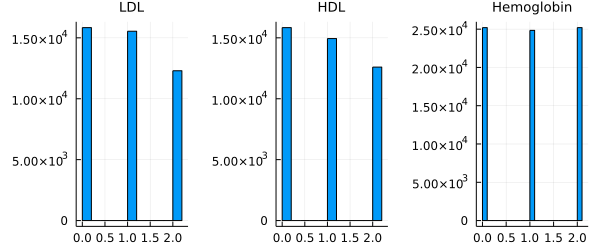

In [44]:
# Visualizing balanced datasets for each task

tr(s::String) = (s=="ok") ? 1 : ((s=="low") ? 0 : 2)

ch_ldl = map(tr, String.(ldl_train_data.ldl)) 
ch_hdl = map(tr, String.(hdl_train_data.hdl))
ch_hgb = map(tr, String.(hgb_train_data.hgb))

# For visualisations
import Plots
Plots.gr()
;

p = Plots.plot(layout = (1,3), size=(600,250))
Plots.histogram!(p[1],ch_ldl,legend=false,title="LDL",titlefontsize=9)
Plots.histogram!(p[2],ch_hdl,legend=false,title="HDL",titlefontsize=9)
Plots.histogram!(p[3],ch_hgb,legend=false,title="Hemoglobin",titlefontsize=9)

In [150]:
# Shuffling individual datasets

using Random
using DataFrames

ldl_train_data = ldl_train_data[randperm(nrow(ldl_train_data)), :]
hdl_train_data = hdl_train_data[randperm(nrow(hdl_train_data)), :]
hgb_train_data = hgb_train_data[randperm(nrow(hgb_train_data)), :]

# Redo this part from earlier to update labels after shuffling

tr(s::String) = (s=="ok") ? 1 : ((s=="low") ? 0 : 2)

ch_ldl = map(tr, String.(ldl_train_data.ldl)) 
ch_hdl = map(tr, String.(hdl_train_data.hdl))
ch_hgb = map(tr, String.(hgb_train_data.hgb))

75240-element Vector{Int64}:
 2
 1
 0
 1
 2
 0
 1
 0
 1
 1
 1
 2
 1
 ⋮
 1
 1
 0
 2
 0
 1
 0
 0
 2
 1
 2
 0

In [151]:
# Preparing the training data

ldl_x_train = Matrix( ldl_train_data[!,1:170] )
hdl_x_train = Matrix( hdl_train_data[!,1:170] )
hgb_x_train = Matrix( hgb_train_data[!,1:170] )

using Flux
using Flux: onehotbatch, argmax, crossentropy, throttle

y_train_ldl = onehotbatch(ch_ldl, 0:2)
y_train_hdl = onehotbatch(ch_hdl, 0:2)
y_train_hgb = onehotbatch(ch_hgb, 0:2)

using LinearAlgebra
ldl_x_train = transpose(ldl_x_train)
hdl_x_train = transpose(hdl_x_train)
hgb_x_train = transpose(hgb_x_train)

170×75240 transpose(::Matrix{Float64}) with eltype Float64:
 0.53247   0.51671   0.471383  0.614675  …  0.4279    0.537129  0.493296
 0.53369   0.516387  0.476211  0.615909     0.430212  0.537447  0.498427
 0.539646  0.524089  0.482293  0.618742     0.434298  0.544604  0.501048
 0.546352  0.535409  0.483198  0.626303     0.440601  0.549231  0.513359
 0.556648  0.539734  0.488571  0.627356     0.447762  0.558075  0.521234
 0.561803  0.547941  0.49777   0.630966  …  0.452312  0.565615  0.528568
 0.56983   0.557985  0.50084   0.636579     0.455878  0.572993  0.530666
 0.571637  0.557889  0.509422  0.641872     0.462948  0.5796    0.532151
 0.587009  0.567573  0.518936  0.654319     0.472151  0.585054  0.538632
 0.598427  0.578858  0.530664  0.660978     0.484383  0.60116   0.549966
 0.613251  0.590828  0.544264  0.673768  …  0.497915  0.614556  0.560935
 0.623228  0.602318  0.553569  0.682826     0.507734  0.626746  0.570739
 0.629522  0.608263  0.559518  0.690905     0.514781  0.632396  

In [155]:
# Defining the neural networks

m_ldl = Chain(
    Dense(170, 32, relu),
    Dense(32, 3),
    softmax)

m_hdl = Chain(
    Dense(170, 32, relu),
    Dense(32, 3),
    softmax)

m_hgb = Chain(
    Dense(170, 32, relu),
    Dense(32, 3),
    softmax)


Chain(
  Dense(170, 32, relu),                 # 5_472 parameters
  Dense(32, 3),                         # 99 parameters
  NNlib.softmax,
)                   # Total: 4 arrays, 5_571 parameters, 22.012 KiB.

In [156]:
# Defining the parameters

using Base.Iterators: repeated
datasetx_ldl = repeated((ldl_x_train, y_train_ldl), 2000)
C_ldl = collect(datasetx_ldl);
evalcb_ldl = () -> @show(loss(ldl_x_train,y_train_ldl))
ps_ldl = Flux.params(m_ldl)

datasetx_hdl = repeated((hdl_x_train, y_train_hdl), 2000)
C_hdl = collect(datasetx_hdl);
evalcb_hdl = () -> @show(loss(hdl_x_train,y_train_hdl))
ps_hdl = Flux.params(m_hdl)

datasetx_hgb = repeated((hgb_x_train, y_train_hgb), 2000)
C_hgb = collect(datasetx_hgb);
evalcb_hgb = () -> @show(loss(hgb_x_train,y_train_hgb))
ps_hgb = Flux.params(m_hgb)

opt = ADAM()

ADAM(0.001, (0.9, 0.999), IdDict{Any, Any}())

In [169]:
# Training for LDL

loss(x, y) = Flux.crossentropy(m_ldl(x), y)
Flux.train!(loss, ps_ldl, datasetx_ldl, opt, cb = throttle(evalcb_ldl, 30))

loss(ldl_x_train, y_train_ldl) = 0.9167535816857876
loss(ldl_x_train, y_train_ldl) = 0.910718471944319
loss(ldl_x_train, y_train_ldl) = 0.911034955969914
loss(ldl_x_train, y_train_ldl) = 0.9104735140627783
loss(ldl_x_train, y_train_ldl) = 0.9097277934123081
loss(ldl_x_train, y_train_ldl) = 0.9154904183677424
loss(ldl_x_train, y_train_ldl) = 0.9091932902116997
loss(ldl_x_train, y_train_ldl) = 0.9088734541996282
loss(ldl_x_train, y_train_ldl) = 0.9085629312270412
loss(ldl_x_train, y_train_ldl) = 0.9082480234052733
loss(ldl_x_train, y_train_ldl) = 0.908875612754736
loss(ldl_x_train, y_train_ldl) = 0.9076835307062078
loss(ldl_x_train, y_train_ldl) = 0.9073814233503021
loss(ldl_x_train, y_train_ldl) = 0.9072184512149969
loss(ldl_x_train, y_train_ldl) = 0.9067926127229909
loss(ldl_x_train, y_train_ldl) = 0.9088561198948083
loss(ldl_x_train, y_train_ldl) = 0.9106897647810854
loss(ldl_x_train, y_train_ldl) = 0.9060908110173318
loss(ldl_x_train, y_train_ldl) = 0.9065536516657461
loss(ldl_x_trai

In [180]:
# Training for HDL

loss(x, y) = Flux.crossentropy(m_hdl(x), y)
Flux.train!(loss, ps_hdl, datasetx_hdl, opt, cb = throttle(evalcb_hdl, 30))

loss(hdl_x_train, y_train_hdl) = 1.0556817462126225
loss(hdl_x_train, y_train_hdl) = 1.0566036199421127
loss(hdl_x_train, y_train_hdl) = 1.056243116130549
loss(hdl_x_train, y_train_hdl) = 1.0545856727862335
loss(hdl_x_train, y_train_hdl) = 1.0545212726688398
loss(hdl_x_train, y_train_hdl) = 1.054376900749564
loss(hdl_x_train, y_train_hdl) = 1.0544451813862248
loss(hdl_x_train, y_train_hdl) = 1.0545406514064932
loss(hdl_x_train, y_train_hdl) = 1.0550228560468995
loss(hdl_x_train, y_train_hdl) = 1.053957579301416
loss(hdl_x_train, y_train_hdl) = 1.0539110300993182
loss(hdl_x_train, y_train_hdl) = 1.0538307241496632
loss(hdl_x_train, y_train_hdl) = 1.057335202322086
loss(hdl_x_train, y_train_hdl) = 1.0535445222066133
loss(hdl_x_train, y_train_hdl) = 1.0539865420947905
loss(hdl_x_train, y_train_hdl) = 1.0533358609983945
loss(hdl_x_train, y_train_hdl) = 1.0532443096505573
loss(hdl_x_train, y_train_hdl) = 1.0531328516096519
loss(hdl_x_train, y_train_hdl) = 1.0530347896249568
loss(hdl_x_train

In [187]:
# Training for HGB

loss(x, y) = Flux.crossentropy(m_hgb(x), y)
Flux.train!(loss, ps_hgb, datasetx_hgb, opt, cb = throttle(evalcb_hgb, 30))

loss(hgb_x_train, y_train_hgb) = 0.9994491627135701
loss(hgb_x_train, y_train_hgb) = 0.9989876859765833
loss(hgb_x_train, y_train_hgb) = 1.000136925458657
loss(hgb_x_train, y_train_hgb) = 0.9986210480005011
loss(hgb_x_train, y_train_hgb) = 0.9986958570974078
loss(hgb_x_train, y_train_hgb) = 0.9973896446184773
loss(hgb_x_train, y_train_hgb) = 0.9970396766942077
loss(hgb_x_train, y_train_hgb) = 0.9968043954723953
loss(hgb_x_train, y_train_hgb) = 0.9962324755236913
loss(hgb_x_train, y_train_hgb) = 1.0105379262043317
loss(hgb_x_train, y_train_hgb) = 0.9955910225859518
loss(hgb_x_train, y_train_hgb) = 0.9951167903243004
loss(hgb_x_train, y_train_hgb) = 0.9947571333234391
loss(hgb_x_train, y_train_hgb) = 0.9946057822600943
loss(hgb_x_train, y_train_hgb) = 0.9940499927537649
loss(hgb_x_train, y_train_hgb) = 0.9936863366593504
loss(hgb_x_train, y_train_hgb) = 1.004804469587891
loss(hgb_x_train, y_train_hgb) = 0.9930941131851081
loss(hgb_x_train, y_train_hgb) = 0.9926816364099572
loss(hgb_x_tra

In [106]:
size(ldl_x_train)

(170, 43680)

In [170]:
cont = 0
for i in 1:43680
    cont = cont + (argmax(m_ldl(ldl_x_train[:,i])) == argmax(y_train_ldl[:,i]) )
end
cont / 43680

0.5758241758241758

In [173]:
size(hdl_x_train)

(170, 43380)

In [181]:
cont = 0
for i in 1:43380
    cont = cont + (argmax(m_hdl(hdl_x_train[:,i])) == argmax(y_train_hdl[:,i]) )
end
cont / 43380

0.44612724757952976

In [183]:
size(hgb_x_train)

(170, 75240)

In [188]:
cont = 0
for i in 1:75240
    cont = cont + (argmax(m_hgb(hgb_x_train[:,i])) == argmax(y_train_hgb[:,i]) )
end
cont / 75240

0.4905236576289208

In [189]:
# Reading in the test dataset

test_data = CSV.read("Updated_Test.csv", DataFrames.DataFrame, header=true)
@info "size of the testing data-set: ", size(test_data);

x_test = Matrix( test_data[!,3:172] )
x_test = transpose(x_test)

┌ Info: ("size of the testing data-set: ", (3660, 176))
└ @ Main In[189]:4


170×3660 transpose(::Matrix{Float64}) with eltype Float64:
 0.517951  0.517839  0.517702  0.525008  …  0.504268  0.508112  0.519984
 0.520508  0.522367  0.522018  0.527439     0.498534  0.508622  0.523291
 0.526852  0.525186  0.527237  0.536871     0.504383  0.511373  0.522272
 0.531611  0.534661  0.534374  0.539636     0.506042  0.516235  0.52476
 0.536816  0.5419    0.541155  0.546555     0.51465   0.523375  0.529858
 0.543828  0.54618   0.547152  0.553183  …  0.522117  0.529093  0.541437
 0.547761  0.551687  0.549837  0.558826     0.528692  0.536244  0.547259
 0.554379  0.556753  0.557513  0.563549     0.533725  0.540203  0.553041
 0.565622  0.566446  0.566793  0.575675     0.544288  0.550041  0.56298
 0.575762  0.578208  0.580574  0.587214     0.555969  0.563505  0.574798
 0.590253  0.591039  0.592258  0.597155  …  0.573758  0.58063   0.591095
 0.600692  0.60162   0.601226  0.606784     0.58665   0.592105  0.602305
 0.605104  0.605895  0.608085  0.612443     0.593866  0.600402  0.6

In [190]:
# Making predictions on the test dataset

ldl_test = m_ldl(x_test)
hdl_test = m_hdl(x_test)
hgb_test = m_hgb(x_test)

3×3660 Matrix{Float64}:
 0.189794  0.192171  0.179908  0.213095  …  0.300733  0.326744  0.373419
 0.348406  0.344525  0.337485  0.342994     0.294087  0.285713  0.28308
 0.4618    0.463305  0.482607  0.443911     0.40518   0.387543  0.343501

In [193]:
# Aggregating the predictions

function sign(x)
    (argmax(x) - 1 == 0) ? -1 : ((argmax(x) - 1 == 1) ? 0 : 1)
end

function result(x)
    if x <= -30
        return "low"
    end
    if x <= 30
        return "ok"
    end
    return "high"
end

df = DataFrame(Donation_ID = [], target = [])
for id in unique(test_data[:,2])
    donation_data = test_data[test_data.donation_id .== id, :]
    test = transpose( Matrix( donation_data[!,3:172] ) )
    rsp_ldl = m_ldl(test)
    rsp_hdl = m_hdl(test)
    rsp_hgb = m_hgb(test)
    count_ldl = 0
    count_hdl = 0
    count_hgb = 0
    for i in 1:size(test,2)
        count_ldl += sign(rsp_ldl[:,i])
        count_hdl += sign(rsp_hdl[:,i])
        count_hgb += sign(rsp_hgb[:,i])
    end
    #print(result(count_ldl))
    print(count_ldl)
    push!(df, [id * "_cholesterol_ldl_human", result(count_ldl)])
    print(" ")
    #print(result(count_hdl))
    print(count_hdl)
    push!(df, [id * "_hdl_cholesterol_human", result(count_hdl)])
    print(" ")
    #print(result(count_hgb))
    print(count_hgb)
    push!(df, [id * "_hemoglobin(hgb)_human", result(count_hgb)])
    println(" ")
end
df

26 -60 60 
58 -60 0 
60 -60 60 
-1 54 53 
0 60 -57 
-60 -60 0 
0 58 -60 
-60 59 0 
-60 -36 39 
-57 -60 7 
-8 36 4 
-40 0 0 
-8 60 24 
0 -60 0 
0 -34 0 
-15 -56 0 
-60 -24 0 
-3 -28 0 
-39 -3 4 
-59 -60 60 
9 -46 60 
-3 -47 60 
-60 0 60 
-60 0 60 
-60 60 -60 
-5 -60 0 
52 0 -60 
-60 -60 46 
-60 2 37 
-60 0 60 
-35 0 51 
6 60 3 
57 -20 -52 
0 -60 0 
60 0 -60 
0 60 4 
-60 17 46 
0 0 58 
0 -59 -54 
-60 0 -48 
1 -39 -60 
-60 -60 55 
-60 -60 60 
13 -1 -58 
1 0 -60 
-20 -60 0 
-31 -26 0 
0 55 -60 
0 -19 -41 
0 -58 0 
0 -60 0 
0 0 -60 
0 -56 -3 
0 -60 60 
0 0 -30 
-60 -60 60 
36 -44 22 
0 0 -60 
2 -60 60 
-55 -60 60 
59 0 28 


,Donation_ID,target
,Any,Any
1,ID_2982_cholesterol_ldl_human,ok
2,ID_2982_hdl_cholesterol_human,low
3,ID_2982_hemoglobin(hgb)_human,high
4,ID_5730_cholesterol_ldl_human,high
5,ID_5730_hdl_cholesterol_human,low
6,ID_5730_hemoglobin(hgb)_human,ok
7,ID_2517_cholesterol_ldl_human,high
8,ID_2517_hdl_cholesterol_human,low
9,ID_2517_hemoglobin(hgb)_human,high


In [192]:
CSV.write("./Submit1.csv", df)

"./Submit1.csv"